In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import random
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,
                                     LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [2]:
# Constants
DATA_PATH = "ravdesszip"
SAMPLE_RATE = 22050
DURATION = 4  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
EMOTIONS = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
FIXED_LENGTH = 173
N_MFCC = 40

# Feature extraction function with augmentation
def extract_features(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(y) < SAMPLES_PER_TRACK:
            padding = SAMPLES_PER_TRACK - len(y)
            y = np.pad(y, (0, padding), mode='constant')

        if augment:
            if random.random() < 0.5:
                y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.uniform(-2, 2))
            if random.random() < 0.5:
                noise_amp = 0.005 * np.random.uniform() * np.amax(y)
                y += noise_amp * np.random.normal(size=y.shape)
            if random.random() < 0.5:
                rate = random.uniform(0.8, 1.2)
                y = librosa.effects.time_stretch(y, rate)
            if random.random() < 0.5:
                shift = np.random.randint(len(y))
                y = np.roll(y, shift)
            if random.random() < 0.5:
                y = librosa.effects.time_mask(y, size=random.randint(0, 20))  # Time Masking
            if random.random() < 0.5:
                y = librosa.effects.freq_mask(y, size=random.randint(0, 10))  # Frequency Masking

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-10)

        if mfcc.shape[1] < FIXED_LENGTH:
            pad_width = FIXED_LENGTH - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :FIXED_LENGTH]

        return mfcc.T
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

In [3]:
# Loading dataset
def load_dataset(data_path):
    X, y = [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    emotion_id = file.split("-")[2]
                    if emotion_id.isdigit() and int(emotion_id) <= len(EMOTIONS):
                        emotion_label = EMOTIONS[int(emotion_id) - 1]
                        feat = extract_features(os.path.join(root, file))
                        if feat is not None:
                            X.append(feat)
                            y.append(emotion_label)
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
    return np.array(X), np.array(y)

print("Loading dataset...")
X, y = load_dataset(DATA_PATH)
print(f"Loaded {len(X)} samples")

Loading dataset...
Loaded 2878 samples


In [4]:
# Balancing dataset using resampling
print("Balancing dataset...")
df = pd.DataFrame({'feature': list(X), 'label': y})
max_count = df['label'].value_counts().max()
balanced = []
for label in df['label'].unique():
    subset = df[df['label'] == label]
    upsampled = resample(subset, replace=True, n_samples=max_count, random_state=42)
    balanced.append(upsampled)
df_balanced = pd.concat(balanced)

X = np.array(df_balanced['feature'].tolist( ))
y = np.array(df_balanced['label'].tolist())

le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))

Balancing dataset...


In [5]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, val_idx in sss.split(x_train, np.argmax(y_train, axis=1)):
    x_train_, x_val_ = x_train[train_idx], x_train[val_idx]
    y_train_, y_val_ = y_train[train_idx], y_train[val_idx]

In [6]:
# Model architecture with enhancements
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(256, 5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),

        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Increased learning rate
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
# Learning rate scheduler function (corrected)
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.05))  # Slower learning rate decay

# Callbacks for training
callbacks = [
    EarlyStopping(patience=15, monitor='val_accuracy', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    LearningRateScheduler(scheduler)
]

# Calculate class weights for imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

# Creating and training the model
model = create_model((FIXED_LENGTH, N_MFCC), len(EMOTIONS))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 173, 256)          51456     
                                                                 
 batch_normalization (BatchN  (None, 173, 256)         1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 86, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 86, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 128)           98432     
                                                                 
 batch_normalization_1 (Batc  (None, 86, 128)          5

In [8]:
history = model.fit(
    x_train_, y_train_,
    validation_data=(x_val_, y_val_),
    epochs=100,  # Number of epochs (tune as needed)
    batch_size=23,  # Larger batch size
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/100
92/92 [==============================] - 7s 53ms/step - loss: 1.8225 - accuracy: 0.2841 - val_loss: 2.3446 - val_accuracy: 0.1243 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 4s 47ms/step - loss: 1.5408 - accuracy: 0.4169 - val_loss: 2.6692 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 4s 47ms/step - loss: 1.2534 - accuracy: 0.5482 - val_loss: 2.3252 - val_accuracy: 0.1432 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 4s 47ms/step - loss: 1.1479 - accuracy: 0.5845 - val_loss: 2.4682 - val_accuracy: 0.1865 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 4s 47ms/step - loss: 1.0719 - accuracy: 0.6156 - val_loss: 1.3085 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 6/100
92/92 [==============================] - 4s 47ms/step - loss: 0.8672 - accuracy: 0.6786 - val_loss: 1.1479 - val_accuracy: 0.5270 - lr: 9.5123e-04
Epoch 7/100
92/92 [==============================] - 4s 47ms/step 

In [9]:
# Evaluating the model
print("Evaluating model...")
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

Evaluating model...
20/20 [==============================] - 0s 16ms/step - loss: 0.2026 - accuracy: 0.9448

Test Accuracy: 94.48%


20/20 [==============================] - 1s 14ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.96      0.99      0.97        77
        calm       1.00      0.97      0.99        77
     disgust       0.94      0.87      0.91        77
     fearful       0.87      0.90      0.88        77
       happy       0.97      0.96      0.97        77
     neutral       0.89      0.96      0.93        77
         sad       0.93      0.96      0.94        77
   surprised       1.00      0.95      0.97        77

    accuracy                           0.94       616
   macro avg       0.95      0.94      0.94       616
weighted avg       0.95      0.94      0.94       616



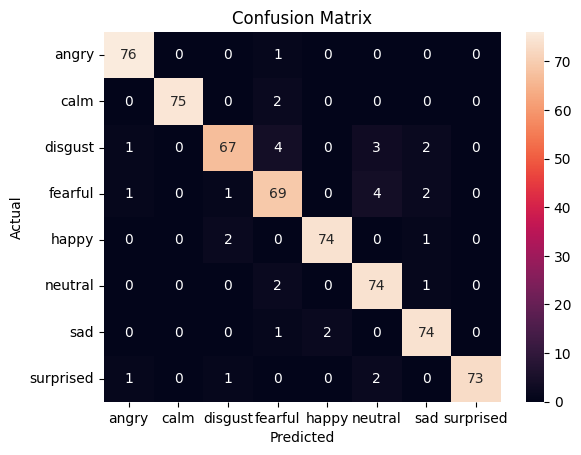

In [10]:
# Predicting and classification report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=EMOTIONS))

# Confusion matrix visualization
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

PROJECT PRESENTATION

C:\Users\Devansh Kumar\AppData\Local\Temp\ipykernel_26884\2603061258.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()), palette="viridis")


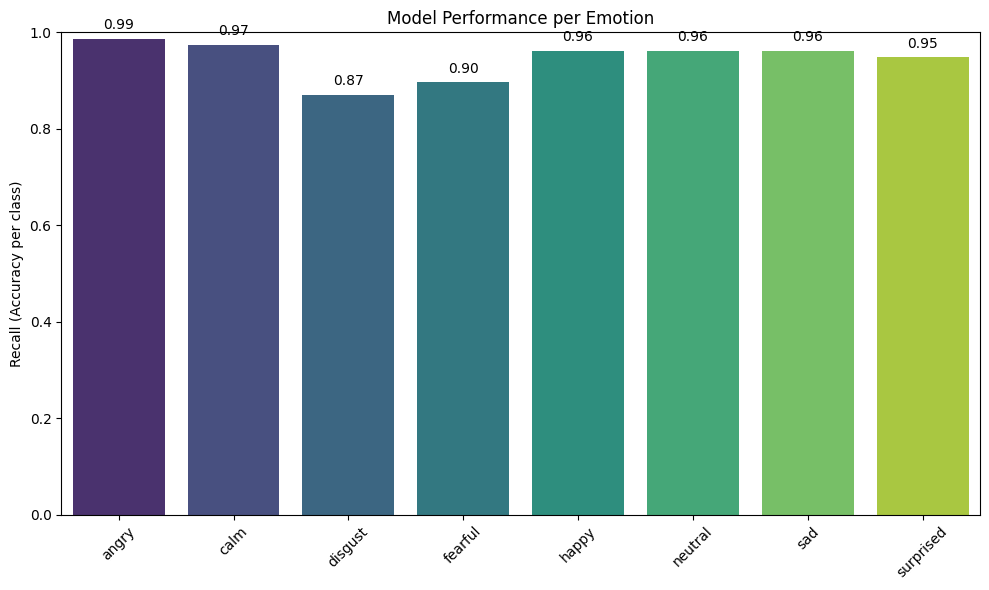

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Convert from one-hot encoded to class labels if needed
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

if y_pred_classes.ndim > 1:
    y_pred_classes = np.argmax(y_pred_classes, axis=1)

# Your emotion labels (update with your actual class names if needed)
emotion_labels =  ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=emotion_labels, output_dict=True)

# Extract recall per class
accuracy_per_class = {label: report[label]['recall'] for label in emotion_labels}

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()), palette="viridis")
plt.ylabel("Recall (Accuracy per class)")
plt.title("Model Performance per Emotion")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Optionally add text labels above bars
for i, v in enumerate(accuracy_per_class.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

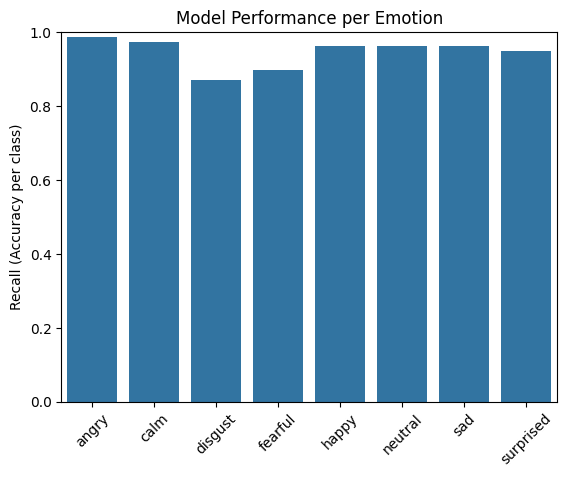

In [12]:
import seaborn as sns

report = classification_report(y_test, y_pred_classes, target_names=emotion_labels, output_dict=True)
accuracy_per_class = {label: report[label]['recall'] for label in emotion_labels}

sns.barplot(x=list(accuracy_per_class.keys()), y=list(accuracy_per_class.values()))
plt.ylabel("Recall (Accuracy per class)")
plt.title("Model Performance per Emotion")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

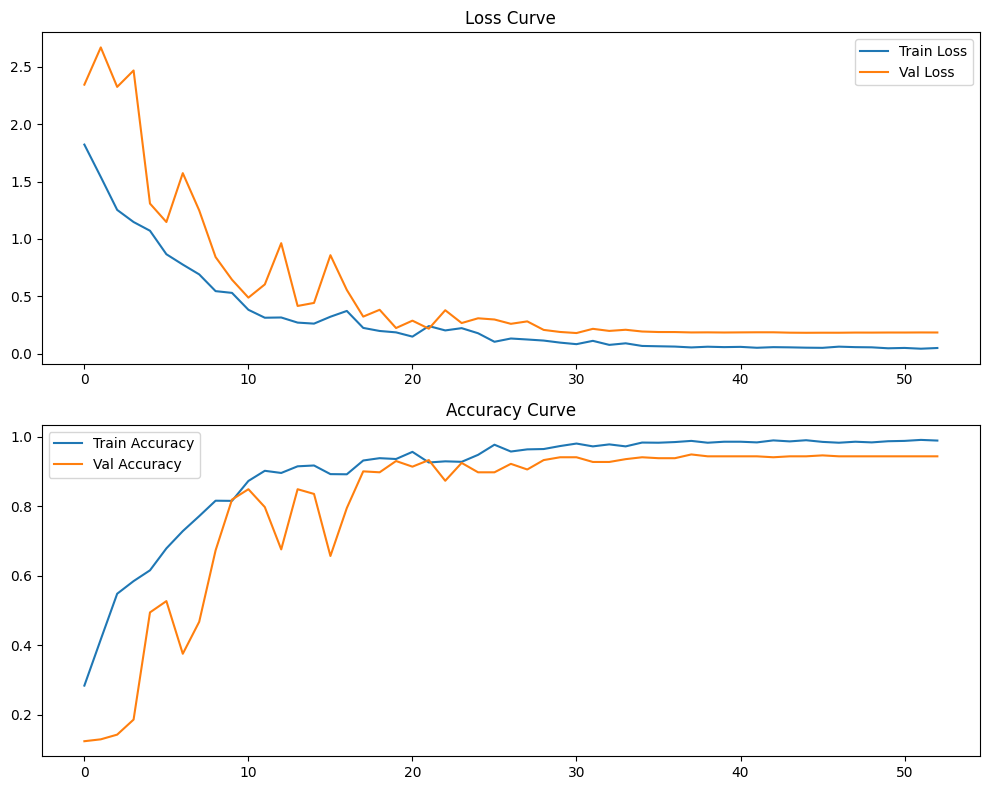

In [13]:
plt.figure(figsize=(10, 8))

# Loss Curve (first row)
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

# Accuracy Curve (second row)
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.show()

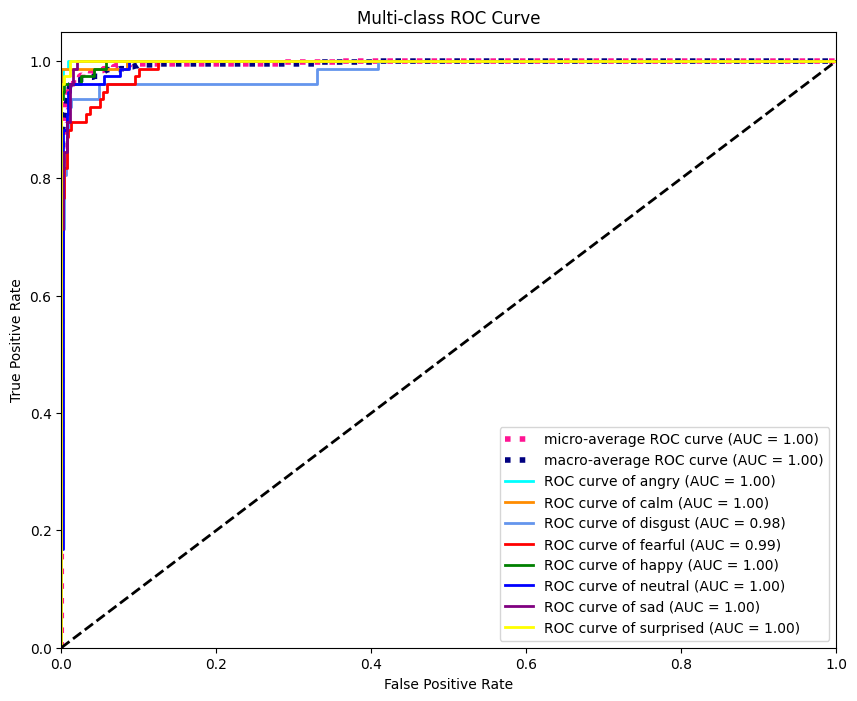

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the output labels
y_test_bin = label_binarize(y_true_classes, classes=np.arange(len(EMOTIONS)))
y_pred_bin = y_pred  # already in probability form for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(EMOTIONS)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'purple', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(EMOTIONS[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
model.save("model.h5")